In [1]:
# Third Party Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from exphelperfunctions import abbrv_num
from exphelperfunctions import objectToFile
from exphelperfunctions import objectFromFile
from exphelperfunctions import add_value_labels

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
#Open UNSW-NB15 small train/test split
df_normal = pd.read_csv('/mnt/h/inSDN/Normal_data.csv', sep=',',header=0,skipinitialspace=True)
df_meta = pd.read_csv('/mnt/h/inSDN/metasploitable-2.csv', sep=',',header=0,skipinitialspace=True)
df_ovs = pd.read_csv('/mnt/h/inSDN/OVS.csv', sep=',',header=0,skipinitialspace=True)

In [4]:
print(df_normal.columns)

Index(['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol',
       'Timestamp', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts',
       'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE 

In [5]:
print(df_normal['Label'].unique())
print(df_meta['Label'].unique())
df_ovs['Label'] = df_ovs['Label'].str.strip()
print(df_ovs['Label'].unique())

#change to binary/multiclass label columns

df_meta['BinLabel'] = 1
df_ovs['BinLabel'] = 1
df_normal['BinLabel'] = 0

['Normal']
['U2R' 'BFA' 'DDoS' 'DoS' 'Probe']
['BFA' 'DDoS' 'DoS' 'Probe' 'Web-Attack' 'BOTNET']


# Data composition
Normal: 68,424 instances (20%)

Meta: 138,772 instances (40.34%)
* DoS: 1145
* DDoS: 73529
* Probe: 61757
* brute-force-attack: 295
* Exploitation (R2L): 17

OVS: 136,743 instances (39.76%)
* DoS: 52471
* DDoS: 48413
* Probe: 36372
* brute-force-attack: 1110
* web_attack: 192
* Botnet: 164

# One hot encoding

In [6]:
print(df_normal['Protocol'].unique())
print(df_meta['Protocol'].unique())
print(df_ovs['Protocol'].unique())

[ 6  0 17]
[ 6 17  0]
[ 6  0 17]


In [7]:
# One hot encoding for protocol
ohe_df = pd.get_dummies(df_normal['Protocol'], prefix="proto")
df_normal = df_normal.join(ohe_df)

ohe_df = pd.get_dummies(df_meta['Protocol'], prefix="proto")
df_meta = df_meta.join(ohe_df)

ohe_df = pd.get_dummies(df_ovs['Protocol'], prefix="proto")
df_ovs = df_ovs.join(ohe_df)

# Combine datasets and select features

In [8]:
#Get input columns and corresponding label vector
#Use duration, protocol, src bytes&packets per flow, dst bytes&packets per flow, mean src/dst bytes per flow, mean src/dst IAT per flow
#features = df_train.drop(['id','proto','service','state','attack_cat','label'],axis=1)
features = ['Flow Duration','proto_0','proto_6','proto_17','TotLen Fwd Pkts','TotLen Bwd Pkts','Fwd Pkt Len Mean','Bwd Pkt Len Mean','Tot Fwd Pkts','Tot Bwd Pkts','Fwd IAT Mean','Bwd IAT Mean']
label = 'BinLabel'
skf = StratifiedKFold(n_splits=5)

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
cfs = []
preds = []
for (tr_nor_idx, te_nor_idx), (tr_met_idx, te_met_idx), (tr_ovs_idx, te_ovs_idx) in \
zip(skf.split(df_normal[features],df_normal['Label']),skf.split(df_meta[features], df_meta['Label']),skf.split(df_ovs[features], df_ovs['Label'])):
    print("TRAIN:", (len(tr_nor_idx)+len(tr_met_idx)+len(tr_ovs_idx)), "TEST:", (len(te_nor_idx)+len(te_met_idx)+len(te_ovs_idx)))
    X_train = pd.concat([df_normal[features].iloc[tr_nor_idx,:],df_meta[features].iloc[tr_met_idx,:],df_ovs[features].iloc[tr_ovs_idx,:]], ignore_index=True)
    X_test = pd.concat([df_normal[features].iloc[te_nor_idx,:],df_meta[features].iloc[te_met_idx,:],df_ovs[features].iloc[te_ovs_idx,:]], ignore_index=True)
    y_train = pd.concat([df_normal[label].iloc[tr_nor_idx],df_meta[label].iloc[tr_met_idx],df_ovs[label].iloc[tr_ovs_idx]], ignore_index=True)
    y_test = pd.concat([df_normal[label].iloc[te_nor_idx],df_meta[label].iloc[te_met_idx],df_ovs[label].iloc[te_ovs_idx]], ignore_index=True)
    #Apply Random Forest
    rf_clf = RandomForestClassifier(n_estimators=100,min_samples_split=10,min_samples_leaf=5,max_samples=0.8,criterion='gini',n_jobs=5, verbose=10)
    rf_clf.fit(X_train,y_train)
    y_pred = rf_clf.predict(X_test)
    cfs.append(confusion_matrix(y_test, y_pred))
    preds.append([y_test, y_pred])

TRAIN: 275110 TEST: 68779
building tree 1 of 100building tree 2 of 100building tree 3 of 100building tree 4 of 100building tree 5 of 100






[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.2s


building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    0.4s


building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100


[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.6s


building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    0.8s


building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:    1.3s


building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100


[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    1.5s


building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100building tree 84 of 100



[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:    1.9s


building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100


[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:    2.2s


building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.1s finished


TRAIN: 275110 TEST: 68779
building tree 1 of 100building tree 2 of 100building tree 3 of 100building tree 4 of 100building tree 5 of 100




building tree 6 of 100
building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.1s


building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    0.4s


building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    0.7s


building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    1.0s


building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:    1.2s


building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100


[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    1.5s


building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100


[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:    1.8s


building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100


[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:    2.0s


building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    2.3s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.0s finished


TRAIN: 275111 TEST: 68778
building tree 1 of 100building tree 2 of 100building tree 3 of 100building tree 4 of 100building tree 5 of 100




building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.1s


building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    0.4s


building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    0.8s


building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    1.0s


building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:    1.2s


building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100


[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    1.5s


building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100


[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:    1.8s


building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


TRAIN: 275112 TEST: 68777
building tree 1 of 100building tree 2 of 100building tree 3 of 100

building tree 4 of 100
building tree 5 of 100

building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.2s


building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    0.3s


building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    0.7s


building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    1.0s


building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100


[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:    1.2s


building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100


[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    1.5s


building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:    1.7s


building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100


[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:    2.1s


building tree 100 of 100


[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    2.3s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.1s finished


TRAIN: 275113 TEST: 68776
building tree 1 of 100building tree 2 of 100building tree 3 of 100
building tree 4 of 100


building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.1s


building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    0.3s


building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    0.7s


building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.9s


building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100


[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:    1.2s


building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100


[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    1.4s


building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100


[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:    1.7s


building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100


[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:    2.0s


building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.0s finished


In [12]:
print(cfs)
cf = np.mean(cfs,axis=(0))
cf_std = np.std(cfs,axis=0)
print(cf)
print(cf_std)
objectToFile(preds, "insdn_preds_"+label)

[array([[13138,   547],
       [ 4853, 50241]]), array([[13264,   421],
       [  205, 54889]]), array([[12824,   861],
       [  173, 54920]]), array([[12940,   745],
       [ 1900, 53192]]), array([[13008,   676],
       [  463, 54629]])]
[[13034.8   650. ]
 [ 1518.8 53574.2]]
[[ 153.18276665  153.14829415]
 [1784.04959572 1783.74767274]]


In [3]:
#Load object from file
from sklearn.metrics import confusion_matrix
label='BinLabel'
preds_mem = objectFromFile("insdn_preds_"+label)
cfs = []
for pred_tuple in preds_mem:
    cfs.append(confusion_matrix(pred_tuple[0], pred_tuple[1]))

In [6]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
paper1_acc = 0.905
paper1_rec = 0.93
#tn, fp, fn, tp = np.mean(cfs,axis=0).ravel()
#print(tn,fp,fn,tp)

#acc_scores = [accuracy_score(pred_tuple[0], pred_tuple[1]) for pred_tuple in preds_mem]
#rec_score  = tp / (tp+fn)
#spec_score = tn / (tn+fp)
acc_scores = [0.988]
rec_score = 0.984
spec_score = 0.998
print(np.mean(acc_scores), "\n")
print(rec_score, "\n")
print(spec_score)

0.988 

0.984 

0.998


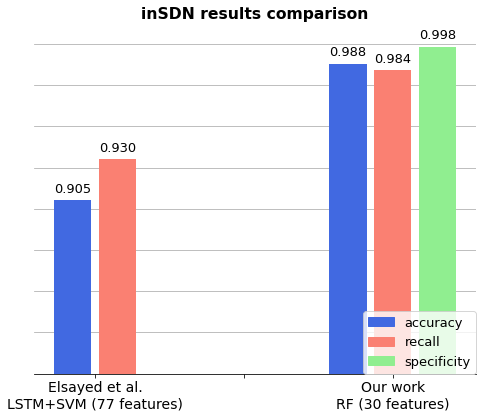

In [7]:
import matplotlib.patches as mpatches
#Colors
clr_acc = 'royalblue'
clr_rec = 'salmon'
clr_spec = 'lightgreen'

acc_patch = mpatches.Patch(color=clr_acc, label='accuracy')
rec_patch = mpatches.Patch(color=clr_rec, label='recall')
spec_patch = mpatches.Patch(color=clr_spec, label='specificity')

labels = ['Elsayed et al.\nLSTM+SVM (77 features)', '', 'Our work\nRF (30 features)']
x = np.arange(len(labels))*10
width = 2.5  # the width of the bars
pad_width = 3
scores = [paper1_acc,paper1_rec,np.mean(acc_scores),rec_score,spec_score]

fig, ax = plt.subplots(figsize=(7,6))

#Spawn bar(s) of group 1
plt.bar(x[0]-pad_width/2, height=scores[0], width=width, color=clr_acc)
plt.bar(x[0]+pad_width/2, height=scores[1], width=width, color=clr_rec)

#Spawn bar(s) of group 2
plt.bar(x[2]-pad_width, height=scores[2], width=width, color=clr_acc)
plt.bar(x[2], height=scores[3], width=width, color=clr_rec)
plt.bar(x[2]+pad_width, height=scores[4], width=width, color=clr_spec)

#Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tick_params(left = False)

#Set plot details
plt.rc('font', size=13)
#plt.ylabel('Metric score')
#plt.yticks(size='14')
plt.xticks(size='14')
ax.set_yticklabels([])
plt.ylim([0.8, 1])
plt.title("inSDN results comparison", fontweight='bold', pad=25)
ax.set_xticks(x)
ax.set_xticklabels(labels)
add_value_labels(ax)
ax.legend(handles=[acc_patch,rec_patch,spec_patch], loc='lower right', borderaxespad=0.)
ax.set_axisbelow(True)
plt.grid(axis='y')
fig.tight_layout()
plt.savefig('inSDN_binaryclass_bars.png',bbox_inches='tight')
plt.show()

In [13]:
for cf in cfs:
    print(cf)

np.set_printoptions(suppress=True)
print('mean\n', np.mean(cfs,axis=0))
print('std. dev\n', np.std(cfs,axis=0))
print('std. dev %\n', np.divide(np.std(cfs,axis=0),np.mean(cfs,axis=0))*100)

[[13138   547]
 [ 4853 50241]]
[[13264   421]
 [  205 54889]]
[[12824   861]
 [  173 54920]]
[[12940   745]
 [ 1900 53192]]
[[13008   676]
 [  463 54629]]
mean
 [[13034.8   650. ]
 [ 1518.8 53574.2]]
std. dev
 [[ 153.18276665  153.14829415]
 [1784.04959572 1783.74767274]]
std. dev %
 [[  1.1751831   23.56127602]
 [117.464419     3.32949008]]


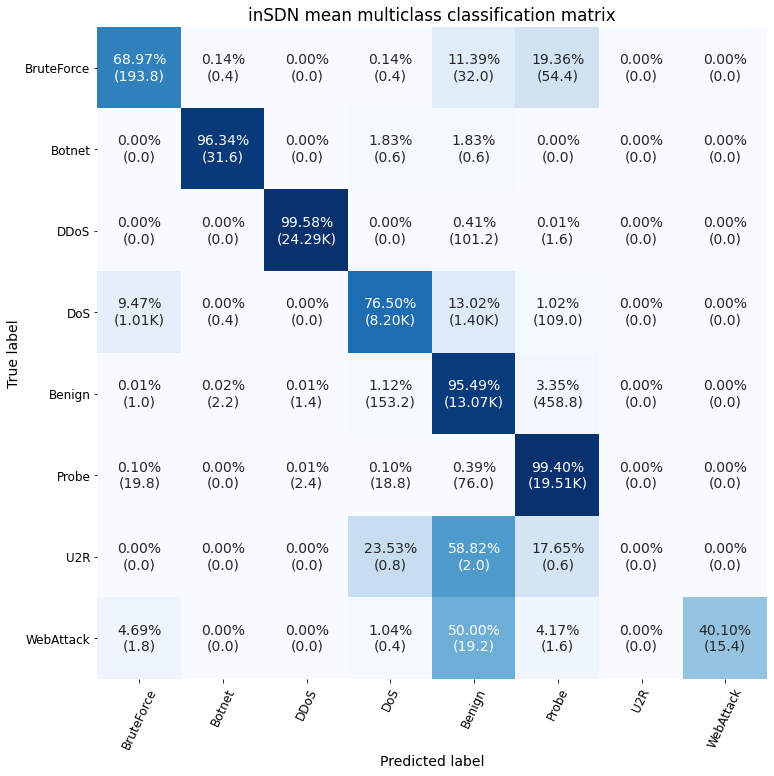

In [18]:
#Plot confusion matrix
import seaborn as sns

#Standard heatmap
cf_norm = cf/cf.sum(axis=1)[:,None]
cf_percentages = ["{0:.2%}".format(value) for value in cf_norm.flatten()]
cf_numbers = [abbrv_num(value) for value in cf.flatten()]
cf_labels = ['{v1}\n({v2})'.format(v1=v1, v2=v2) for v1,v2 in zip(cf_percentages,cf_numbers)]
cf_labels = np.asarray(cf_labels).reshape(cf.shape)

fig, ax = plt.subplots(figsize=(12, 12))
plt.rc('font', size=14)
column_labels = ['BruteForce', 'Botnet','DDoS','DoS','Benign','Probe','U2R',\
                'WebAttack']
#column_labels = ['Benign', 'Malicious']
sns.heatmap(cf_norm, annot=cf_labels, fmt='',cmap='Blues',cbar=False, vmin=0.0, vmax=1.0, ax=ax, xticklabels=column_labels, yticklabels=column_labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.yticks(rotation='0', size='12')
plt.xticks(rotation='65', size='12')
plt.title("inSDN mean multiclass classification matrix")
plt.savefig('inSDN_multiclass_cf.png',bbox_inches='tight')
plt.show()

In [14]:
importance = rf_clf.feature_importances_
# summarize feature importance
for i,v in sorted(enumerate(importance),key=lambda x: x[1], reverse=True):
    print('Feature: %s, Score: %.5f' % (features[i],v))

Feature: Fwd Pkt Len Mean, Score: 0.17827
Feature: Bwd Pkt Len Mean, Score: 0.16290
Feature: TotLen Bwd Pkts, Score: 0.12883
Feature: Tot Fwd Pkts, Score: 0.09583
Feature: Tot Bwd Pkts, Score: 0.08518
Feature: TotLen Fwd Pkts, Score: 0.06970
Feature: Flow Duration, Score: 0.06739
Feature: Fwd IAT Mean, Score: 0.06739
Feature: Bwd IAT Mean, Score: 0.05178
Feature: proto_17, Score: 0.04822
Feature: proto_6, Score: 0.02454
Feature: proto_0, Score: 0.01998


# N-grams experiment

### Show amount of source IPs with more than 'threshold' flows

In [13]:
threshold = 2
vc_norm = df_normal['Src IP'].value_counts()
res_norm = df_normal[df_normal['Src IP'].isin(vc_norm[vc_norm>threshold].index)]['Src IP'].value_counts()
print(res_norm)
vc_meta = df_meta['Src IP'].value_counts()
res_meta = df_meta[df_meta['Src IP'].isin(vc_meta[vc_meta>threshold].index)]['Src IP'].value_counts()
print(res_meta)
vc_ovs = df_ovs['Src IP'].value_counts()
res_ovs = df_ovs[df_ovs['Src IP'].isin(vc_ovs[vc_ovs>threshold].index)]['Src IP'].value_counts()
print(res_ovs)

192.168.20.133    53790
185.127.17.56      3917
192.168.20.2       3223
192.168.20.1        680
74.125.168.10       505
                  ...  
172.253.116.95        3
104.20.111.39         3
205.185.216.10        3
34.243.175.214        3
209.85.203.155        3
Name: Src IP, Length: 379, dtype: int64
192.168.3.130    37362
200.175.2.130    25852
Name: Src IP, dtype: int64
200.175.2.130     84947
192.168.20.134     5116
172.17.0.2          136
192.168.20.132       41
192.168.20.131       41
172.17.0.1           27
Name: Src IP, dtype: int64


## Transform interesting features to N-gram representation

### df_normal:

In [14]:
#Per source IP, grab N-gram and transform numerical features into new
#Done for bigrams and trigrams

features = ['Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', \
            'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', \
            'Fwd Pkt Len Min', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', \
            'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', \
            'Flow IAT Max', 'Flow IAT Min']

#Create/reset columns for n_gram features
for feature in features:
    column_mean = 'tg_' + feature + '_mean'
    column_std = 'tg_' + feature + '_std'
    if column_mean not in df_normal.columns:
        df_normal[column_mean] = np.nan
    if column_std not in df_normal.columns:
        df_normal[column_std] = np.nan

#List of ngram features
featurelist = df_normal.filter(regex='^tg', axis=1).columns
#Window size 2 = bigrams, 3 = trigrams
winsize = 3
#Window type
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=winsize)
for itr, (srcIP, _) in enumerate(res_norm.iteritems()):
    sub_df = df_normal[df_normal['Src IP'] == srcIP]
    for feature in features:
        column_mean = 'tg_' + feature + '_mean'
        column_std = 'tg_' + feature + '_std'
        sub_df.loc[:,column_mean] = sub_df[feature].rolling(window=indexer, min_periods=winsize).mean()
        sub_df.loc[:,column_std] = sub_df[feature].rolling(window=indexer, min_periods=winsize).std()
    df_normal.loc[:,featurelist] = df_normal[featurelist].combine_first(sub_df[featurelist])
    print('Progress: ' + str(itr+1) + '/' + str(len(res_norm)), end='\r')
    
    

/home/arjen/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


### df_meta

In [8]:
#Per source IP, grab N-gram and transform numerical features into new
#Done for bigrams and trigrams

features = ['Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', \
            'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', \
            'Fwd Pkt Len Min', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', \
            'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', \
            'Flow IAT Max', 'Flow IAT Min']

#Create/reset columns for n_gram features
for feature in features:
    column_mean = 'tg_' + feature + '_mean'
    column_std = 'tg_' + feature + '_std'
    if column_mean not in df_meta.columns:
        df_meta[column_mean] = np.nan
    if column_std not in df_meta.columns:
        df_meta[column_std] = np.nan

#List of ngram features
featurelist = df_meta.filter(regex='^tg', axis=1).columns
#Window size 2 = bigrams, 3 = trigrams
winsize = 3
#Window type
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=winsize)
for itr, (srcIP, _) in enumerate(res_meta.iteritems()):
    sub_df = df_meta[df_meta['Src IP'] == srcIP]
    for feature in features:
        column_mean = 'tg_' + feature + '_mean'
        column_std = 'tg_' + feature + '_std'
        sub_df.loc[:,column_mean] = sub_df[feature].rolling(window=indexer, min_periods=winsize).mean()
        sub_df.loc[:,column_std] = sub_df[feature].rolling(window=indexer, min_periods=winsize).std()
    df_meta.loc[:,featurelist] = df_meta[featurelist].combine_first(sub_df[featurelist])
    print('Progress: ' + str(itr+1) + '/' + str(len(res_meta)), end='\r')
    
    

### df_ovs

In [9]:
#Per source IP, grab N-gram and transform numerical features into new
#Done for bigrams and trigrams

features = ['Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', \
            'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', \
            'Fwd Pkt Len Min', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', \
            'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', \
            'Flow IAT Max', 'Flow IAT Min']

#Create/reset columns for n_gram features
for feature in features:
    column_mean = 'tg_' + feature + '_mean'
    column_std = 'tg_' + feature + '_std'
    if column_mean not in df_ovs.columns:
        df_ovs[column_mean] = np.nan
    if column_std not in df_ovs.columns:
        df_ovs[column_std] = np.nan

#List of ngram features
featurelist = df_ovs.filter(regex='^tg', axis=1).columns
#Window size 2 = bigrams, 3 = trigrams
winsize = 3
#Window type
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=winsize)
for itr, (srcIP, _) in enumerate(res_ovs.iteritems()):
    sub_df = df_ovs[df_ovs['Src IP'] == srcIP]
    for feature in features:
        column_mean = 'tg_' + feature + '_mean'
        column_std = 'tg_' + feature + '_std'
        sub_df.loc[:,column_mean] = sub_df[feature].rolling(window=indexer, min_periods=winsize).mean()
        sub_df.loc[:,column_std] = sub_df[feature].rolling(window=indexer, min_periods=winsize).std()
    df_ovs.loc[:,featurelist] = df_ovs[featurelist].combine_first(sub_df[featurelist])
    print('Progress: ' + str(itr+1) + '/' + str(len(res_ovs)), end='\r')
    
    

In [18]:
#Drop rows without ngram features
df_normal.dropna(subset=df_normal.filter(regex='^tg', axis=1).columns, axis=0, how='any', inplace=True)
print(len(df_normal.dropna(subset=df_normal.filter(regex='^tg', axis=1).columns, axis=0, how='any')))
df_meta.dropna(subset=df_meta.filter(regex='^tg', axis=1).columns, axis=0, how='any', inplace=True)
print(len(df_meta.dropna(subset=df_meta.filter(regex='^tg', axis=1).columns, axis=0, how='any')))
df_ovs.dropna(subset=df_ovs.filter(regex='^tg', axis=1).columns, axis=0, how='any', inplace=True)
print(len(df_ovs.dropna(subset=df_ovs.filter(regex='^tg', axis=1).columns, axis=0, how='any')))

66948
63210
90296


In [19]:
print(df_normal.shape)
print(df_meta.shape)
print(df_ovs.shape)

(66948, 118)
(63210, 118)
(90296, 118)


In [33]:
# Compare ngram feature set to normal feature set
features = df_normal.filter(regex='^tg', axis=1).columns
#features = ['Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', \
            'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', \
            'Fwd Pkt Len Min', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', \
            'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', \
            'Flow IAT Max', 'Flow IAT Min']

label = 'BinLabel'
skf = StratifiedKFold(n_splits=5)

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
cfs = []
preds = []
for (tr_nor_idx, te_nor_idx), (tr_met_idx, te_met_idx), (tr_ovs_idx, te_ovs_idx) in \
zip(skf.split(df_normal[features],df_normal['Label']),skf.split(df_meta[features], df_meta['Label']),skf.split(df_ovs[features], df_ovs['Label'])):
    print("TRAIN:", (len(tr_nor_idx)+len(tr_met_idx)+len(tr_ovs_idx)), "TEST:", (len(te_nor_idx)+len(te_met_idx)+len(te_ovs_idx)))
    X_train = pd.concat([df_normal[features].iloc[tr_nor_idx,:],df_meta[features].iloc[tr_met_idx,:],df_ovs[features].iloc[tr_ovs_idx,:]], ignore_index=True)
    X_test = pd.concat([df_normal[features].iloc[te_nor_idx,:],df_meta[features].iloc[te_met_idx,:],df_ovs[features].iloc[te_ovs_idx,:]], ignore_index=True)
    y_train = pd.concat([df_normal[label].iloc[tr_nor_idx],df_meta[label].iloc[tr_met_idx],df_ovs[label].iloc[tr_ovs_idx]], ignore_index=True)
    y_test = pd.concat([df_normal[label].iloc[te_nor_idx],df_meta[label].iloc[te_met_idx],df_ovs[label].iloc[te_ovs_idx]], ignore_index=True)
    #Apply Random Forest
    rf_clf = RandomForestClassifier(n_estimators=100,min_samples_split=10,min_samples_leaf=5,max_samples=0.8,criterion='gini',n_jobs=5, verbose=10)
    rf_clf.fit(X_train,y_train)
    y_pred = rf_clf.predict(X_test)
    cfs.append(confusion_matrix(y_test, y_pred))
    preds.append([y_test, y_pred])

TRAIN: 176362 TEST: 44092
building tree 1 of 100building tree 2 of 100building tree 3 of 100building tree 4 of 100building tree 5 of 100




building tree 6 of 100
building tree 7 of 100


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.2s


building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    0.5s


building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100


[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.7s


building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    0.9s


building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    1.2s


building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100


[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:    1.5s


building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100


[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    1.8s


building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100


[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:    2.2s


building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100


[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:    2.6s


building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    2.9s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


TRAIN: 176363 TEST: 44091
building tree 1 of 100building tree 2 of 100building tree 3 of 100building tree 4 of 100building tree 5 of 100




building tree 6 of 100
building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.3s


building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    0.5s


building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100


[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.7s


building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    0.9s


building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    1.2s


building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100building tree 60 of 100

building tree 61 of 100
building tree 62 of 100
building tree 63 of 100


[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:    1.5s


building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100


[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    1.8s


building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100


[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:    2.2s


building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100


[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:    2.5s


building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    2.9s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


TRAIN: 176363 TEST: 44091
building tree 1 of 100building tree 2 of 100building tree 3 of 100building tree 4 of 100building tree 5 of 100




building tree 6 of 100
building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.3s


building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    0.5s


building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100


[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.7s


building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    1.0s


building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    1.3s


building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100


[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:    1.6s


building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100


[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    1.9s


building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100


[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:    2.2s


building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100


[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:    2.6s


building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    2.9s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.0s finished


TRAIN: 176364 TEST: 44090
building tree 1 of 100building tree 2 of 100building tree 3 of 100building tree 4 of 100building tree 5 of 100




building tree 6 of 100
building tree 7 of 100


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.2s


building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    0.4s


building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100


[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    0.9s


building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    1.2s


building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100


[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:    1.5s


building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100


[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    1.8s


building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100


[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:    2.2s


building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100


[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:    2.6s


building tree 100 of 100


[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    2.9s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


TRAIN: 176364 TEST: 44090
building tree 1 of 100building tree 2 of 100building tree 3 of 100building tree 4 of 100building tree 5 of 100




building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.3s


building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100


[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    0.5s


building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.7s


building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100


[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    0.9s


building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    1.2s


building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:    1.4s


building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100


[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    1.8s


building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100


[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:    2.1s


building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100building tree 91 of 100

building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100


[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:    2.5s


building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    2.8s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.0s finished


In [35]:
print(cfs)
cf = np.mean(cfs,axis=(0))
cf_std = np.std(cfs,axis=0)
print(cf)
print(cf_std)
objectToFile(preds, "insdn_trigrams_normal_preds_"+label)

[array([[12898,   492],
       [ 1410, 29292]]), array([[12915,   475],
       [  248, 30453]]), array([[12591,   799],
       [  154, 30547]]), array([[12650,   739],
       [ 1953, 28748]]), array([[12753,   636],
       [   72, 30629]])]
[[12761.4   628.2]
 [  767.4 29933.8]]
[[129.43662542 129.25231139]
 [767.88009481 767.71281089]]


In [6]:
from sklearn.metrics import classification_report, confusion_matrix
label = 'BinLabel'
preds_mem = objectFromFile("insdn_trigrams_normal_preds_"+label)
cfs = []
for pred_tuple in preds_mem:
    cfs.append(confusion_matrix(pred_tuple[0], pred_tuple[1]))

In [7]:
for cf in cfs:
    print(cf)

cf = np.mean(cfs,axis=(0))
np.set_printoptions(suppress=True)
print('mean\n', cf)
print('std. dev\n', np.std(cfs,axis=0))
print('std. dev %\n', np.divide(np.std(cfs,axis=0),np.mean(cfs,axis=0))*100)

[[12898   492]
 [ 1410 29292]]
[[12915   475]
 [  248 30453]]
[[12591   799]
 [  154 30547]]
[[12650   739]
 [ 1953 28748]]
[[12753   636]
 [   72 30629]]
mean
 [[12761.4   628.2]
 [  767.4 29933.8]]
std. dev
 [[129.43662542 129.25231139]
 [767.88009481 767.71281089]]
std. dev %
 [[  1.01428233  20.57502569]
 [100.06256122   2.56470215]]


### Ngram feature set results

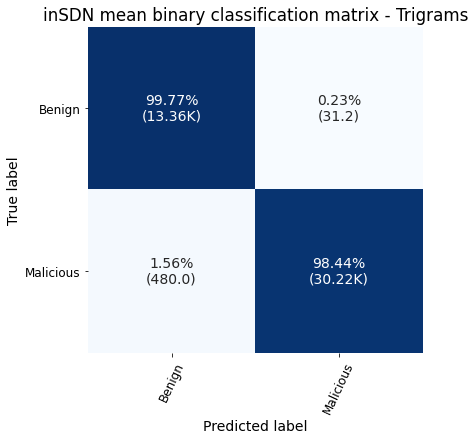

In [29]:
#Plot confusion matrix
import seaborn as sns

#Standard heatmap
cf_norm = cf/cf.sum(axis=1)[:,None]
cf_percentages = ["{0:.2%}".format(value) for value in cf_norm.flatten()]
cf_numbers = [abbrv_num(value) for value in cf.flatten()]
cf_labels = ['{v1}\n({v2})'.format(v1=v1, v2=v2) for v1,v2 in zip(cf_percentages,cf_numbers)]
cf_labels = np.asarray(cf_labels).reshape(cf.shape)

fig, ax = plt.subplots(figsize=(6, 6))
plt.rc('font', size=14)
#column_labels = ['BruteForce', 'Botnet','DDoS','DoS','Benign','Probe','U2R',\
#                'WebAttack']
column_labels = ['Benign', 'Malicious']
sns.heatmap(cf_norm, annot=cf_labels, fmt='',cmap='Blues',cbar=False, vmin=0.0, vmax=1.0, ax=ax, xticklabels=column_labels, yticklabels=column_labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.yticks(rotation='0', size='12')
plt.xticks(rotation='65', size='12')
plt.title("inSDN mean binary classification matrix - Trigrams")
plt.savefig('inSDN_binaryclass_cf_trigrams.png',bbox_inches='tight')
plt.show()

In [5]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
tn, fp, fn, tp = np.mean(cfs,axis=0).ravel()
print(tn,fp,fn,tp)

acc_scores = [accuracy_score(pred_tuple[0], pred_tuple[1]) for pred_tuple in preds_mem]
rec_score  = tp / (tp+fn)
spec_score = tn / (tn+fp)
print('Accuracy: ' + str(np.mean(acc_scores)), "\n")
print('Recall: ' + str(rec_score), "\n")
print('Specificity: ' + str(spec_score))

13358.4 31.2 480.0 30221.2
Accuracy: 0.9884056889691477 

Recall: 0.9843654319700859 

Specificity: 0.9976698333034594


In [30]:
importance = rf_clf.feature_importances_
# summarize feature importance
for i,v in sorted(enumerate(importance),key=lambda x: x[1], reverse=True):
    print('Feature: %s, Score: %.5f' % (features[i],v))

Feature: ngram_Bwd Pkt Len Min_std, Score: 0.13518
Feature: ngram_Bwd Pkt Len Min_mean, Score: 0.11703
Feature: ngram_Fwd Pkt Len Min_mean, Score: 0.10277
Feature: ngram_Fwd Pkt Len Min_std, Score: 0.09600
Feature: ngram_Tot Bwd Pkts_mean, Score: 0.08374
Feature: ngram_TotLen Bwd Pkts_std, Score: 0.06858
Feature: ngram_TotLen Bwd Pkts_mean, Score: 0.04664
Feature: ngram_Tot Fwd Pkts_mean, Score: 0.04149
Feature: ngram_Tot Fwd Pkts_std, Score: 0.03520
Feature: ngram_Fwd Pkt Len Max_std, Score: 0.03507
Feature: ngram_Bwd Pkt Len Max_mean, Score: 0.03075
Feature: ngram_Tot Bwd Pkts_std, Score: 0.03037
Feature: ngram_Bwd Pkt Len Max_std, Score: 0.02557
Feature: ngram_Flow Byts/s_std, Score: 0.02475
Feature: ngram_Fwd Pkt Len Max_mean, Score: 0.01917
Feature: ngram_Flow Byts/s_mean, Score: 0.01572
Feature: ngram_TotLen Fwd Pkts_mean, Score: 0.01194
Feature: ngram_TotLen Fwd Pkts_std, Score: 0.01019
Feature: ngram_Flow IAT Min_mean, Score: 0.01001
Feature: ngram_Flow Pkts/s_mean, Score: 0.00

### Normal feature set results

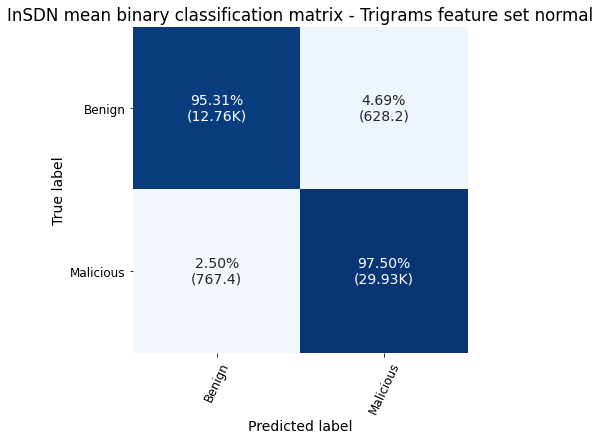

In [37]:
#Plot confusion matrix
import seaborn as sns

#Standard heatmap
cf_norm = cf/cf.sum(axis=1)[:,None]
cf_percentages = ["{0:.2%}".format(value) for value in cf_norm.flatten()]
cf_numbers = [abbrv_num(value) for value in cf.flatten()]
cf_labels = ['{v1}\n({v2})'.format(v1=v1, v2=v2) for v1,v2 in zip(cf_percentages,cf_numbers)]
cf_labels = np.asarray(cf_labels).reshape(cf.shape)

fig, ax = plt.subplots(figsize=(6, 6))
plt.rc('font', size=14)
#column_labels = ['BruteForce', 'Botnet','DDoS','DoS','Benign','Probe','U2R',\
#                'WebAttack']
column_labels = ['Benign', 'Malicious']
sns.heatmap(cf_norm, annot=cf_labels, fmt='',cmap='Blues',cbar=False, vmin=0.0, vmax=1.0, ax=ax, xticklabels=column_labels, yticklabels=column_labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.yticks(rotation='0', size='12')
plt.xticks(rotation='65', size='12')
plt.title("InSDN mean binary classification matrix - Trigrams feature set normal")
plt.savefig('insdn_binaryclass_cf_trigrams_normal.png',bbox_inches='tight')
plt.show()

In [8]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
tn, fp, fn, tp = np.mean(cfs,axis=0).ravel()
print(tn,fp,fn,tp)

acc_scores = [accuracy_score(pred_tuple[0], pred_tuple[1]) for pred_tuple in preds_mem]
rec_score  = tp / (tp+fn)
spec_score = tn / (tn+fp)
print('Accuracy: ' + str(np.mean(acc_scores)), "\n")
print('Recall: ' + str(rec_score), "\n")
print('Specificity: ' + str(spec_score))

12761.4 628.2 767.4 29933.8
Accuracy: 0.9683471276318748 

Recall: 0.9750042343621748 

Specificity: 0.9530829897831152


In [38]:
importance = rf_clf.feature_importances_
# summarize feature importance
for i,v in sorted(enumerate(importance),key=lambda x: x[1], reverse=True):
    print('Feature: %s, Score: %.5f' % (features[i],v))

Feature: Bwd Pkt Len Max, Score: 0.12712
Feature: TotLen Bwd Pkts, Score: 0.11595
Feature: Fwd Pkt Len Max, Score: 0.10737
Feature: Bwd Pkt Len Min, Score: 0.10229
Feature: Tot Fwd Pkts, Score: 0.08280
Feature: Tot Bwd Pkts, Score: 0.08008
Feature: Fwd Pkt Len Min, Score: 0.07254
Feature: TotLen Fwd Pkts, Score: 0.06610
Feature: Flow IAT Min, Score: 0.05775
Feature: Flow Byts/s, Score: 0.05131
Feature: Flow IAT Std, Score: 0.03526
Feature: Flow Duration, Score: 0.03182
Feature: Flow IAT Max, Score: 0.02651
Feature: Flow IAT Mean, Score: 0.02170
Feature: Flow Pkts/s, Score: 0.02142


## Barplot of own feature sets

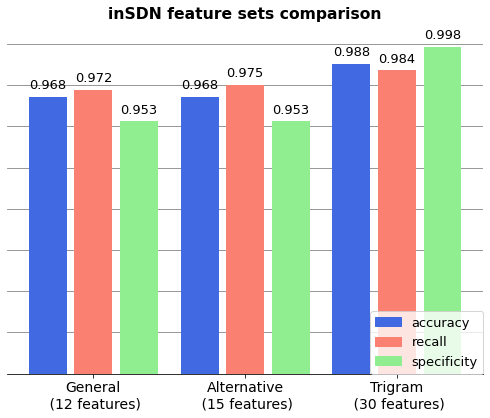

In [4]:
import matplotlib.patches as mpatches

#Scores
genset_acc = 0.968
genset_rec = 0.972
genset_spec = 0.953
trigramset_acc = 0.988
trigramset_rec = 0.984
trigramset_spec = 0.998
altset_acc = 0.968
altset_rec = 0.975
altset_spec = 0.953

#Colors
clr_acc = 'royalblue'
clr_rec = 'salmon'
clr_spec = 'lightgreen'

acc_patch = mpatches.Patch(color=clr_acc, label='accuracy')
rec_patch = mpatches.Patch(color=clr_rec, label='recall')
spec_patch = mpatches.Patch(color=clr_spec, label='specificity')

labels = ['General\n (12 features)', 'Alternative\n (15 features)', \
          'Trigram\n (30 features)']

x = np.arange(len(labels))*10
width = 2.5  # the width of the bars
pad_width = 3
scores = [genset_acc,genset_rec,genset_spec,altset_acc,altset_rec,altset_spec, trigramset_acc, trigramset_rec, trigramset_spec]

fig, ax = plt.subplots(figsize=(7,6))

#Spawn bar(s) of group 1
plt.bar(x[0]-pad_width, height=scores[0], width=width, color=clr_acc)
plt.bar(x[0], height=scores[1], width=width, color=clr_rec)
plt.bar(x[0]+pad_width, height=scores[2], width=width, color=clr_spec)

#Spawn bar(s) of group 2
plt.bar(x[1]-pad_width, height=scores[3], width=width, color=clr_acc)
plt.bar(x[1], height=scores[4], width=width, color=clr_rec)
plt.bar(x[1]+pad_width, height=scores[5], width=width, color=clr_spec)

#Spawn bar(s) of group 3
plt.bar(x[2]-pad_width, height=scores[6], width=width, color=clr_acc)
plt.bar(x[2], height=scores[7], width=width, color=clr_rec)
plt.bar(x[2]+pad_width, height=scores[8], width=width, color=clr_spec)

#Hide the left, right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tick_params(left = False)

#Set plot details
plt.rc('font', size=13)
#plt.ylabel('Metric score')
plt.yticks()
ax.set_yticklabels([])
plt.ylim([0.8, 1])
#ax.get_yaxis().set_visible(False)
plt.xticks(size='14')
plt.title("inSDN feature sets comparison", fontweight='bold', pad=25)
ax.set_xticks(x)
ax.set_xticklabels(labels)
add_value_labels(ax)
#ax.legend(handles=[acc_patch,rec_patch,spec_patch],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax.legend(handles=[acc_patch,rec_patch,spec_patch], loc='lower right', borderaxespad=0.)
ax.set_axisbelow(True)
plt.grid(axis='y', color='grey')
fig.tight_layout()
plt.savefig('inSDN_binaryclass_featuresets_bars.png',bbox_inches='tight')
plt.show()

## Print inSDN instance examples for all 3 feature sets

In [15]:
gen_features = ['Flow Duration','proto_0','proto_6','proto_17','TotLen Fwd Pkts','TotLen Bwd Pkts','Fwd Pkt Len Mean','Bwd Pkt Len Mean','Tot Fwd Pkts','Tot Bwd Pkts','Fwd IAT Mean','Bwd IAT Mean']
alt_features = ['Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', \
            'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', \
            'Fwd Pkt Len Min', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', \
            'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', \
            'Flow IAT Max', 'Flow IAT Min']
tg_features = df_normal.filter(regex='^tg', axis=1).columns
label = 'BinLabel'

In [11]:
df_normal[gen_features].head(3)

,Flow Duration,proto_0,proto_6,proto_17,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Mean,Bwd Pkt Len Mean,Tot Fwd Pkts,Tot Bwd Pkts,Fwd IAT Mean,Bwd IAT Mean
0,245230,0,1,0,124937.0,1071.0,2839.477273,26.775000,44,40,5548.00000,6287.948718
1,1605449,0,1,0,1071.0,439537.0,10.009346,2949.912752,107,149,12567.17925,10831.959460
2,53078,0,1,0,66.0,758.0,13.200000,151.600000,5,5,12575.50000,13240.500000


In [12]:
df_normal[alt_features].head(3)

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Bwd Pkt Len Max,Bwd Pkt Len Min,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min
0,245230,44,40,124937.0,1071.0,9100,0,517,0,513835.99070,342.535579,2954.578313,7953.221927,64066.0,-44.0
1,1605449,107,149,1071.0,439537.0,517,0,27300,0,274445.34210,159.456949,6295.878431,56408.330520,859760.0,-102.0
2,53078,5,5,66.0,758.0,66,0,638,0,15524.32269,188.401974,5897.555556,15184.845200,46232.0,19.0


In [16]:
df_normal[tg_features].head(3)

,tg_Flow Duration_mean,tg_Flow Duration_std,tg_Tot Fwd Pkts_mean,tg_Tot Fwd Pkts_std,tg_Tot Bwd Pkts_mean,tg_Tot Bwd Pkts_std,tg_TotLen Fwd Pkts_mean,tg_TotLen Fwd Pkts_std,tg_TotLen Bwd Pkts_mean,tg_TotLen Bwd Pkts_std,...,tg_Flow Pkts/s_mean,tg_Flow Pkts/s_std,tg_Flow IAT Mean_mean,tg_Flow IAT Mean_std,tg_Flow IAT Std_mean,tg_Flow IAT Std_std,tg_Flow IAT Max_mean,tg_Flow IAT Max_std,tg_Flow IAT Min_mean,tg_Flow IAT Min_std
0,89183.000000,135148.396687,15.666667,24.542480,14.000000,22.516660,41645.666667,72132.410582,357.000000,618.342138,...,262.141594,71.450654,6323.692771,3379.760677,5553.275908,4824.007856,28746.333333,30618.505782,3272.000000,5579.744439
1,616222.666667,859431.859086,41.666667,56.721542,56.666667,80.151939,639.000000,517.123776,150460.000000,250401.269324,...,166.792439,19.033258,6328.061329,447.466069,28175.490543,24476.260099,314837.666667,471932.332972,-45.666667,60.928920
2,82666.666667,96157.159361,6.666667,5.686241,7.333333,7.767453,292.333333,422.694137,3947.666667,6192.720431,...,322.801386,264.471989,5026.268519,2325.920429,9848.596567,7379.135597,29384.333333,22830.989123,448.666667,808.248930
